## Tutorial 3.2

The Linnerud dataset is a multi-output regression dataset. It consists of three excercise (data) and three physiological (target) variables collected from twenty middle-aged men in a fitness club:

physiological - CSV containing 20 observations on 3 physiological variables: Weight, Waist and Pulse.

exercise - CSV containing 20 observations on 3 exercise variables: Chins, Situps and Jumps.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import torch
from torch import nn

In [2]:
SEED = 100
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
from sklearn.datasets import load_linnerud

X, y = load_linnerud(return_X_y=True)

In [4]:
df1 = pd.DataFrame(X, columns=["chins", "sit_ups", "jumps"])
print(df1[:5])

   chins  sit_ups  jumps
0    5.0    162.0   60.0
1    2.0    110.0   60.0
2   12.0    101.0  101.0
3   12.0    105.0   37.0
4   13.0    155.0   58.0


In [5]:
df2 = pd.DataFrame(y, columns=["weight","waist","pulse"])
print(df2[:5])

   weight  waist  pulse
0   191.0   36.0   50.0
1   189.0   37.0   52.0
2   193.0   38.0   58.0
3   162.0   35.0   62.0
4   189.0   35.0   46.0


In [6]:
df = pd.merge(df1,df2, left_index=True, right_index=True)
df.describe()

,chins,sit_ups,jumps,weight,waist,pulse
count,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000
mean,9.450000,145.550000,70.30000,178.600000,35.400000,56.100000
std,5.286278,62.566575,51.27747,24.690505,3.201973,7.210373
min,1.000000,50.000000,25.00000,138.000000,31.000000,46.000000
25%,4.750000,101.000000,39.50000,160.750000,33.000000,51.500000
50%,11.500000,122.500000,54.00000,176.000000,35.000000,55.000000
75%,13.250000,210.000000,85.25000,191.500000,37.000000,60.500000
max,17.000000,251.000000,250.00000,247.000000,46.000000,74.000000


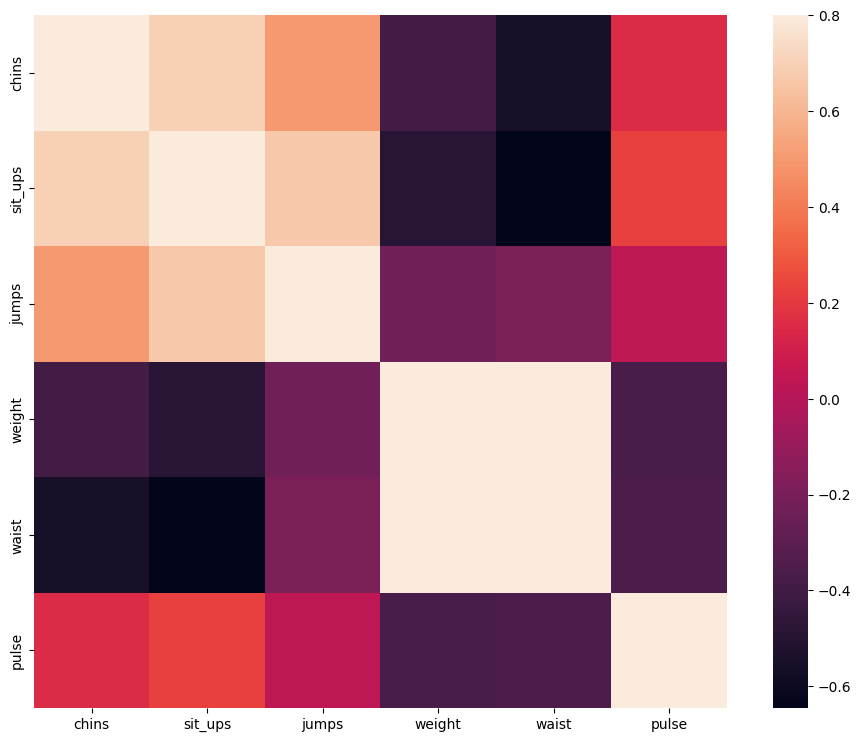

In [7]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [8]:
from sklearn.model_selection import train_test_split

# Split into validation and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15, 3), (5, 3), (15, 3), (5, 3))

In [9]:
# preprocess input and output data
from sklearn import preprocessing

# normal Gaussian scaling for inputs
X_scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = X_scaler.transform(X_train)

# linear scaling upto [0,1] for outputs
y_scaler = preprocessing.MinMaxScaler().fit(y_train)
y_scaled = y_scaler.transform(y_train)

In [10]:
# Perceptron layer
class PerceptronLayer(nn.Module):
  def __init__(self, no_inputs, no_outputs):
        super().__init__()
        self.perceptron_layer = nn.Sequential(
            nn.Linear(no_inputs, no_outputs),
            nn.Sigmoid()
        )

  def forward(self, x):
        logits = self.perceptron_layer(x)
        return logits

no_inputs, no_outputs = 3, 3

model = PerceptronLayer(no_inputs, no_outputs)
print(f"Model structure: {model}\n\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")
    
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001)

no_epochs, lr = 50000, 0.0011
loss_ = []
t = 0
for epoch in range(no_epochs):
    # Compute prediction and loss
    pred = model(torch.tensor(X_scaled, dtype=torch.float))
    loss = loss_fn(pred, torch.tensor(y_scaled, dtype=torch.float))
    
    # Backpropagation
    
    start = time.time()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    t += time.time() - start
    
    loss_.append(loss.item())
    
    
    if epoch%1000 == 999:
        print('Epoch %4d:  loss=%2.5f'%(epoch+1, loss_[-1]))

print('time for a weight update: %2.5f'%(t*1000/no_epochs))

Model structure: PerceptronLayer(
  (perceptron_layer): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
    (1): Sigmoid()
  )
)


Layer: perceptron_layer.0.weight | Size: torch.Size([3, 3]) | Values : Parameter containing:
tensor([[-0.4484,  0.3647, -0.2742],
        [-0.0186,  0.2038,  0.2932],
        [-0.2740, -0.5279, -0.3371]], requires_grad=True) 

Layer: perceptron_layer.0.bias | Size: torch.Size([3]) | Values : Parameter containing:
tensor([-0.4411, -0.4368,  0.2720], requires_grad=True) 

Epoch 1000:  loss=0.10854
Epoch 2000:  loss=0.10319
Epoch 3000:  loss=0.09815
Epoch 4000:  loss=0.09344
Epoch 5000:  loss=0.08907
Epoch 6000:  loss=0.08504
Epoch 7000:  loss=0.08135
Epoch 8000:  loss=0.07798
Epoch 9000:  loss=0.07495
Epoch 10000:  loss=0.07222
Epoch 11000:  loss=0.06979
Epoch 12000:  loss=0.06764
Epoch 13000:  loss=0.06574
Epoch 14000:  loss=0.06407
Epoch 15000:  loss=0.06261
Epoch 16000:  loss=0.06132
Epoch 17000:  loss=0.06019
Epoch 18000:  loss=0.059

Text(0.5, 1.0, 'gd with alpha = 0.0011')

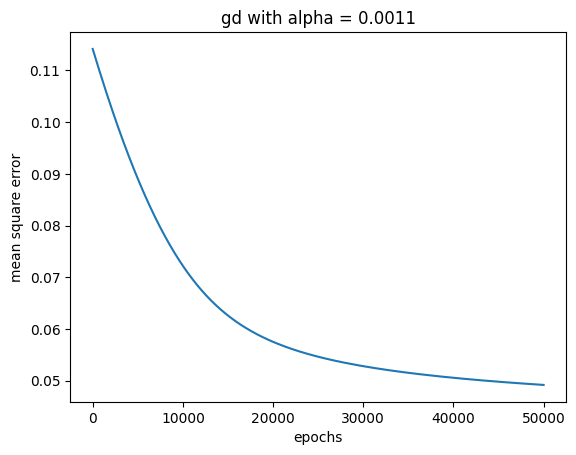

In [11]:
# plot learning curves
plt.figure(1)
plt.plot(range(no_epochs), loss_)
plt.xlabel('epochs')
plt.ylabel('mean square error')
plt.title('gd with alpha = {}'.format(lr))

In [12]:
X_scaled = X_scaler.transform(X_test)
y_pred = model(torch.tensor(X_scaled, dtype=torch.float))
y_scaled = (y_pred - torch.tensor(y_scaler.min_))/torch.tensor(y_scaler.scale_)
loss = loss_fn(y_scaled, torch.tensor(y_test, dtype=torch.float)).item()

y_hat = y_scaled.detach().numpy()
print(y_hat, y_test)
print(loss)

[[173.82744956  35.22933981  57.57895577]
 [191.0523366   38.00277388  55.23074198]
 [181.76253375  36.27688146  56.51424515]
 [164.98154458  33.99987733  59.05447185]
 [169.60507444  35.99412209  56.49006486]] [[162.  35.  62.]
 [176.  37.  54.]
 [211.  38.  56.]
 [169.  34.  50.]
 [193.  38.  58.]]
126.5600243620588


In [13]:
from sklearn.metrics import root_mean_squared_error

rms = root_mean_squared_error(y_scaled.detach().numpy(), y_test, multioutput='raw_values')
rms*rms

array([356.95227178,   1.61016719,  21.11763412])

In [14]:
from sklearn.metrics import r2_score

r2 = r2_score(y_scaled.detach().numpy(), y_test,  multioutput='raw_values')
r2

array([ -3.18467906,   0.06741378, -11.90990362])

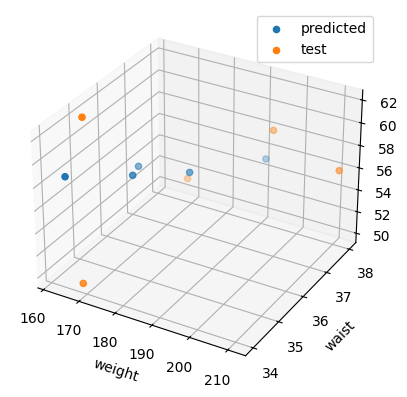

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(y_hat[:,0], y_hat[:,1], y_hat[:,2], label='predicted')
ax.scatter(y_test[:,0], y_test[:,1], y_test[:,2], label = 'test')

ax.set_xlabel('weight')
ax.set_ylabel('waist')
ax.set_zlabel('pulse')
plt.legend()